# Analysis of Test Set 2
This notebook allows for the analysis of Test Set 2. Scroll down to see the chemical structures and the associated AF scores (with standard deviation) with or without inclusion of conformations that could (optionally!) be considered outliers. However, note that in absence of true TS geometries none of these guessed can really be considered an outlier.

In [1]:
import glob
import math
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import mpl_toolkits.axisartist as axisartist
from matplotlib.pyplot import *
from matplotlib import font_manager
from matplotlib.font_manager import FontProperties
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1 import host_subplot


 Define functions:

In [2]:
# Function to check if a value can be converted to a float.
def is_float(string: any) -> bool:
    if string is None:
        return False
    try:
        float(string)
        return True
    except ValueError:
        return False

# Function to extract all properties from an sdf file. (takes regex paths as input) 
def extract_properties_from_sdf(pathname):
    if not os.path.isfile(pathname):
        print("ERROR: file '%s' is missing!" % pathname)
    pattern = re.compile("^> *<.*>$")
    basename = os.path.basename(pathname)
    if not '_out.sdf' in basename:
        raise ValueError("Attempt to extract properties from file that is not an '_out.sdf file!")
    if not '-' in basename or basename.count('-') != 1:
        raise ValueError("Attempt to extract repetition number from malformulated filename '%s'!" % pathname)
    name_parts = basename.replace('_out.sdf','').rpartition('-')
    all_values = {}
    all_values["NAME"] = name_parts[0]
    all_values["REPETITION"] = name_parts[2]
    with open(pathname, "r") as input_file:
        lines = input_file.readlines()
        for index, line in enumerate(lines):
            if pattern.match(line):
                property_name = re.split('<|>', line)[2]
                value_str = lines[index + 1].rstrip()
                if is_float(value_str):
                    all_values[property_name] = float(value_str)
                else:
                    all_values[property_name] = value_str
    return all_values


# Function for plotting the fitness ascore and its components (descriptors and weights) 
# in two subplots so that the role of both descriptors and weights can be detected visually.
def plot_fitness_and_components(df_to_plot):
    rows_descriptors=['DESCRIPTOR_1', 'DESCRIPTOR_2', 'DESCRIPTOR_3', 'FITNESS']
    rows_weights=['WEIGHT_1', 'WEIGHT_2', 'WEIGHT_3', 'WEIGHT_4']
    descriptors_df=df_to_plot[rows_descriptors]
    weights_df=df_to_plot[rows_weights]
    fig, axs = plt.subplots(2, 1, figsize=(10, 5), gridspec_kw={'height_ratios': [2, 1]})
    descriptor_styles = {
        'DESCRIPTOR_1': {'color': 'green', 'linestyle': '--', 'marker': 's', 'legend': r'$D_{1}$'},
        'DESCRIPTOR_2': {'color': 'blue', 'linestyle': '--', 'marker': 'D', 'legend': r'$D_{2}$'},
        'DESCRIPTOR_3': {'color': 'orange', 'linestyle': '--', 'marker': '^', 'legend': r'$D_{3}$'},
        'FITNESS': {'color': 'red', 'linestyle': '-', 'marker': 's', 'legend': 'AF'}
    }

    # First subplot
    for column in descriptors_df.columns:
        style = descriptor_styles.get(column, {'color': 'black', 'linestyle': '-', 'marker': 'o', 'legend': column})
        axs[0].plot(descriptors_df.index, descriptors_df[column], color=style['color'], linestyle=style['linestyle'], marker=style['marker'], label=style['legend'])
    axs[0].set_xlabel('')
    axs[0].set_ylabel('Descriptor Value')
    axs[0].set_title('')
    axs[0].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    #axs[0].set_ylim(-1, 20)  # Set y-axis range
    axs[0].legend()
    axs[0].grid(True, linestyle='--')
    
    # Define the styles and legend names for the second subplot
    weight_styles = {
        'WEIGHT_1': {'color': 'cyan', 'linestyle': ':', 'marker': 'D', 'markersize': 8, 'legend': r'$w_{1}$'},
        'WEIGHT_2': {'color': 'brown', 'linestyle': ':', 'marker': 'v', 'legend': r'$w_{2}$'},
        'WEIGHT_3': {'color': 'magenta', 'linestyle': ':', 'marker': 'o', 'legend': r'$w_{3}$'},
        'WEIGHT_4': {'color': 'black', 'linestyle': ':', 'marker': 'x', 'legend': r'$w_{4}$'}
    }
    
    # Second subplot
    for column in weights_df.columns:
        style = weight_styles.get(column, {'color': 'black', 'linestyle': '-', 'marker': 'o', 'legend': column})
        axs[1].plot(weights_df.index, weights_df[column], color=style['color'], linestyle=style['linestyle'], marker=style['marker'], markersize=style.get('markersize', 6), label=style['legend'])
    axs[1].set_xlabel('')
    axs[1].set_ylabel('Weight Value')
    axs[1].set_title('')
    axs[1].set_ylim(0, 1.1)  # Set y-axis range
    
    # Set font properties for X-axis ticks
    font_properties = font_manager.FontProperties(family='Arial', weight='bold', size=12)
    for label in axs[1].get_xticklabels():
        label.set_fontproperties(font_properties)
    
    axs[1].legend()
    axs[1].grid(True, linestyle='--')
    
    plt.tight_layout()
    plt.show()


# Function to plot the data for a specific catalyst (i.e., all data with the given 'NAME' value).
def plot_one_series(series_name):
    plot_fitness_and_components(df_all_evaluations.loc[df_all_evaluations['NAME'].eq(series_name)])


# Prints the values of the columns given as argument for the group with the given name.
def get_values_for_series(column_names, group_name):
    print(df_all_evaluations.loc[df_all_evaluations['NAME'].eq(group_name)][column_names])
    

In [3]:
# Collect paths to all the sdf files of test set 1 in 'pathnames' variable.
pathnames = sorted(glob.glob('*/*_out.sdf'))
print("Found %d _out.sdf files" % len(pathnames))

Found 114 _out.sdf files


In [4]:
# create dataframe with the name, descriptors, wights and fitness data.
allMolsData = []
for pathname in pathnames:
    molData = extract_properties_from_sdf(pathname)
    if not 'FITNESS' in molData:
        print("WARNING: Ignoring pathname '%s': fitness value not found! " % pathname)
        continue;
    allMolsData.append(molData)
    
df_all_evaluations = pd.DataFrame(allMolsData)
df_all_evaluations

,NAME,REPETITION,FrozenCore-PM6_ENERGY,RMSD_CONF_CG-CS,RMSD_CONF_GO-CS,UID,DESCRIPTOR_DEFINITION_1,DESCRIPTOR_DEFINITION_2,DESCRIPTOR_DEFINITION_3,WEIGHT_DEFINITION_1,...,DESCRIPTOR_2,DESCRIPTOR_3,WEIGHT_1,WEIGHT_2,WEIGHT_3,WEIGHT_4,FITNESS,G_PCy3,G_HI_precursor,DDG_reference_HGII
0,CAACCyDIPP,0,-168.585,0.852814,0.0,,"desc1=( echo ""1 * ( e( $hartree_to_kcalmol * (...","desc1=( echo ""1 * ( e( $hartree_to_kcalmol * (...","desc1=( echo ""1 * ( e( $hartree_to_kcalmol * (...","w1=$( echo ""1 / ( 1 + e( $hartree_to_kcalmol *...",...,10.365993,1.000000e-10,0.076684,1.000000,1.000000,1.000000,0.795150,NaN,NaN,NaN
1,CAACCyDIPP,1,-168.592,0.944688,0.0,,"desc1=( echo ""1 * ( e( $hartree_to_kcalmol * (...","desc1=( echo ""1 * ( e( $hartree_to_kcalmol * (...","desc1=( echo ""1 * ( e( $hartree_to_kcalmol * (...","w1=$( echo ""1 / ( 1 + e( $hartree_to_kcalmol *...",...,9.008872,1.000000e-10,0.076662,1.000000,1.000000,1.000000,0.690666,NaN,NaN,NaN
2,CAACCyDIPP,2,-168.526,0.893641,0.0,,"desc1=( echo ""1 * ( e( $hartree_to_kcalmol * (...","desc1=( echo ""1 * ( e( $hartree_to_kcalmol * (...","desc1=( echo ""1 * ( e( $hartree_to_kcalmol * (...","w1=$( echo ""1 / ( 1 + e( $hartree_to_kcalmol *...",...,10.366714,1.000000e-10,0.072089,1.000000,1.000000,1.000000,0.747552,NaN,NaN,NaN
3,CAACCyDIPP,3,-168.544,1.018228,0.0,,"desc1=( echo ""1 * ( e( $hartree_to_kcalmol * (...","desc1=( echo ""1 * ( e( $hartree_to_kcalmol * (...","desc1=( echo ""1 * ( e( $hartree_to_kcalmol * (...","w1=$( echo ""1 / ( 1 + e( $hartree_to_kcalmol *...",...,9.549603,1.000000e-10,0.076559,1.000000,1.000000,1.000000,0.731177,NaN,NaN,NaN
4,CAACCyDIPP,4,-168.001,0.852393,0.0,,"desc1=( echo ""1 * ( e( $hartree_to_kcalmol * (...","desc1=( echo ""1 * ( e( $hartree_to_kcalmol * (...","desc1=( echo ""1 * ( e( $hartree_to_kcalmol * (...","w1=$( echo ""1 / ( 1 + e( $hartree_to_kcalmol *...",...,8.996573,1.000000e-10,0.075545,1.000000,1.000000,1.000000,0.679670,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,triphenylTriazole,1,488.919,1.107253,0.0,,"desc1=( echo ""1 * ( e( $hartree_to_kcalmol * (...","desc1=( echo ""1 * ( e( $hartree_to_kcalmol * (...","desc1=( echo ""1 * ( e( $hartree_to_kcalmol * (...","w1=$( echo ""1 / ( 1 + e( $hartree_to_kcalmol *...",...,7.993454,1.000000e-10,0.999831,0.999999,0.999999,0.999998,7.992147,NaN,NaN,NaN
110,triphenylTriazole,2,474.435,2.885038,0.0,,"desc1=( echo ""1 * ( e( $hartree_to_kcalmol * (...","desc1=( echo ""1 * ( e( $hartree_to_kcalmol * (...","desc1=( echo ""1 * ( e( $hartree_to_kcalmol * (...","w1=$( echo ""1 / ( 1 + e( $hartree_to_kcalmol *...",...,7.993674,1.000000e-10,0.999831,0.999997,1.000000,0.999999,7.992364,NaN,NaN,NaN
111,triphenylTriazole,3,476.877,2.713684,0.0,,"desc1=( echo ""1 * ( e( $hartree_to_kcalmol * (...","desc1=( echo ""1 * ( e( $hartree_to_kcalmol * (...","desc1=( echo ""1 * ( e( $hartree_to_kcalmol * (...","w1=$( echo ""1 / ( 1 + e( $hartree_to_kcalmol *...",...,7.993969,1.000000e-10,0.999834,0.999999,0.999999,0.999999,7.992683,NaN,NaN,NaN
112,triphenylTriazole,4,473.852,0.270923,0.0,,"desc1=( echo ""1 * ( e( $hartree_to_kcalmol * (...","desc1=( echo ""1 * ( e( $hartree_to_kcalmol * (...","desc1=( echo ""1 * ( e( $hartree_to_kcalmol * (...","w1=$( echo ""1 / ( 1 + e( $hartree_to_kcalmol *...",...,7.992481,1.000000e-10,0.999833,0.999999,0.999999,0.999998,7.991192,NaN,NaN,NaN


Sort by the value of the 'FITNESS'

In [5]:
sorted_index_1 = df_all_evaluations['FITNESS'].sort_values().index
df_all_evaluations_sorted = df_all_evaluations.loc[sorted_index_1]
df_all_evaluations_sorted

,NAME,REPETITION,FrozenCore-PM6_ENERGY,RMSD_CONF_CG-CS,RMSD_CONF_GO-CS,UID,DESCRIPTOR_DEFINITION_1,DESCRIPTOR_DEFINITION_2,DESCRIPTOR_DEFINITION_3,WEIGHT_DEFINITION_1,...,DESCRIPTOR_2,DESCRIPTOR_3,WEIGHT_1,WEIGHT_2,WEIGHT_3,WEIGHT_4,FITNESS,G_PCy3,G_HI_precursor,DDG_reference_HGII
52,IPrP,4,173.385,0.448575,0.0,,"desc1=( echo ""1 * ( e( $hartree_to_kcalmol * (...","desc1=( echo ""1 * ( e( $hartree_to_kcalmol * (...","desc1=( echo ""1 * ( e( $hartree_to_kcalmol * (...","w1=$( echo ""1 / ( 1 + e( $hartree_to_kcalmol *...",...,9.384007,7.790346e-03,0.999901,0.999991,0.056944,1.0,0.534782,NaN,NaN,NaN
4,CAACCyDIPP,4,-168.001,0.852393,0.0,,"desc1=( echo ""1 * ( e( $hartree_to_kcalmol * (...","desc1=( echo ""1 * ( e( $hartree_to_kcalmol * (...","desc1=( echo ""1 * ( e( $hartree_to_kcalmol * (...","w1=$( echo ""1 / ( 1 + e( $hartree_to_kcalmol *...",...,8.996573,1.000000e-10,0.075545,1.000000,1.000000,1.0,0.679670,NaN,NaN,NaN
5,CAACCyDIPP,5,-168.377,0.938778,0.0,,"desc1=( echo ""1 * ( e( $hartree_to_kcalmol * (...","desc1=( echo ""1 * ( e( $hartree_to_kcalmol * (...","desc1=( echo ""1 * ( e( $hartree_to_kcalmol * (...","w1=$( echo ""1 / ( 1 + e( $hartree_to_kcalmol *...",...,9.000872,1.000000e-10,0.076640,1.000000,1.000000,1.0,0.689853,NaN,NaN,NaN
1,CAACCyDIPP,1,-168.592,0.944688,0.0,,"desc1=( echo ""1 * ( e( $hartree_to_kcalmol * (...","desc1=( echo ""1 * ( e( $hartree_to_kcalmol * (...","desc1=( echo ""1 * ( e( $hartree_to_kcalmol * (...","w1=$( echo ""1 / ( 1 + e( $hartree_to_kcalmol *...",...,9.008872,1.000000e-10,0.076662,1.000000,1.000000,1.0,0.690666,NaN,NaN,NaN
3,CAACCyDIPP,3,-168.544,1.018228,0.0,,"desc1=( echo ""1 * ( e( $hartree_to_kcalmol * (...","desc1=( echo ""1 * ( e( $hartree_to_kcalmol * (...","desc1=( echo ""1 * ( e( $hartree_to_kcalmol * (...","w1=$( echo ""1 / ( 1 + e( $hartree_to_kcalmol *...",...,9.549603,1.000000e-10,0.076559,1.000000,1.000000,1.0,0.731177,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,SpiroCAAC,1,5.142,0.238807,0.0,,"desc1=( echo ""1 * ( e( $hartree_to_kcalmol * (...","desc1=( echo ""1 * ( e( $hartree_to_kcalmol * (...","desc1=( echo ""1 * ( e( $hartree_to_kcalmol * (...","w1=$( echo ""1 / ( 1 + e( $hartree_to_kcalmol *...",...,18.764595,1.000000e-10,0.996615,0.999994,1.000000,1.0,2301.682342,NaN,NaN,NaN
77,SpiroCAAC,5,6.147,0.282531,0.0,,"desc1=( echo ""1 * ( e( $hartree_to_kcalmol * (...","desc1=( echo ""1 * ( e( $hartree_to_kcalmol * (...","desc1=( echo ""1 * ( e( $hartree_to_kcalmol * (...","w1=$( echo ""1 / ( 1 + e( $hartree_to_kcalmol *...",...,18.765705,1.000000e-10,0.996618,0.999994,1.000000,1.0,2305.769490,NaN,NaN,NaN
83,SpiroCAACDMeO,5,-314.307,0.737266,0.0,,"desc1=( echo ""1 * ( e( $hartree_to_kcalmol * (...","desc1=( echo ""1 * ( e( $hartree_to_kcalmol * (...","desc1=( echo ""1 * ( e( $hartree_to_kcalmol * (...","w1=$( echo ""1 / ( 1 + e( $hartree_to_kcalmol *...",...,19.821653,1.000000e-10,0.997580,0.999991,1.000000,1.0,12511.349441,NaN,NaN,NaN
79,SpiroCAACDMeO,1,-314.410,0.782939,0.0,,"desc1=( echo ""1 * ( e( $hartree_to_kcalmol * (...","desc1=( echo ""1 * ( e( $hartree_to_kcalmol * (...","desc1=( echo ""1 * ( e( $hartree_to_kcalmol * (...","w1=$( echo ""1 / ( 1 + e( $hartree_to_kcalmol *...",...,19.821842,1.000000e-10,0.997599,0.999990,1.000000,1.0,12515.355371,NaN,NaN,NaN


Group by name to get the statistics for each catalyst

In [6]:
df_gruped = df_all_evaluations_sorted.groupby('NAME')
df_summary = df_gruped['FITNESS'].describe()
df_summary.reindex(df_summary['mean'].sort_values().index)[['mean','std']]

,mean,std
NAME,,
CAACCyDIPP,0.722345,0.044484
IPrP,2.182486,2.004994
tetraMeSIPh,5.851131,0.918492
DFP,6.132873,0.550690
CyDIPP,7.656693,0.224664
triphenylTriazole,8.014728,0.055181
CpMes,8.327468,0.227441
SIMesI,9.010396,0.010916
dPhSIMesCyclohexyl,9.238926,1.206137


CAACCyDIPP  AF = 0.72 +/- 0.04


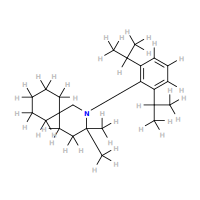

CAACEtDIPP  AF = 13.00 +/- 1.15


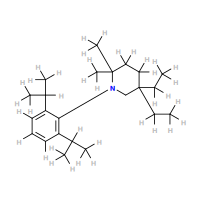

CpMes  AF = 8.33 +/- 0.23


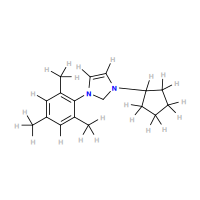

CyDIPP  AF = 7.66 +/- 0.22


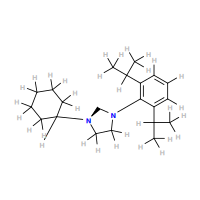

DFP  AF = 6.13 +/- 0.55


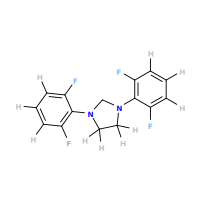

DIPP  AF = 14.12 +/- 0.10


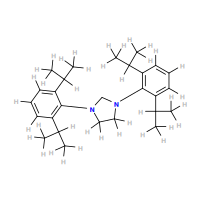

DIPP5CAAC  AF = 17.16 +/- 2.42


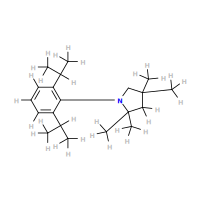

DMIMes  AF = 19.39 +/- 0.04


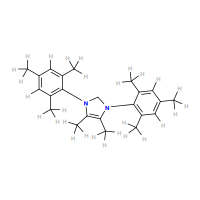

IPrP  AF = 2.18 +/- 2.00


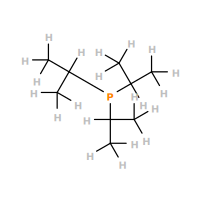

SIMesBenzyl  AF = 11.13 +/- 0.92


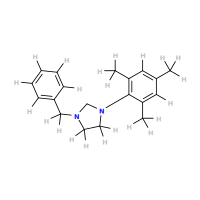

SIMesBr  AF = 11.97 +/- 0.08


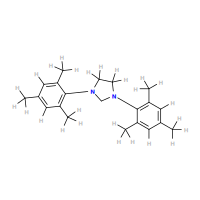

SIMesI  AF = 9.01 +/- 0.01


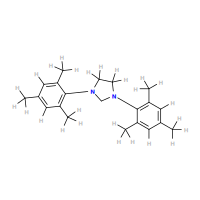

SpiroCAAC  AF = 1907.50 +/- 934.17


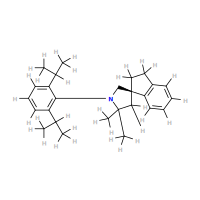

SpiroCAACDMeO  AF = 6479.61 +/- 6618.74


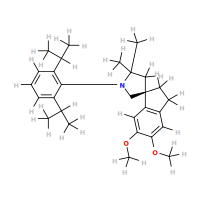

dPhSIMesCyclohexyl  AF = 9.24 +/- 1.21


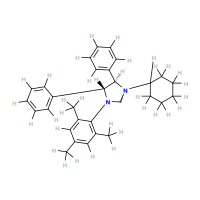

orthoTolyl  AF = 10.93 +/- 0.47


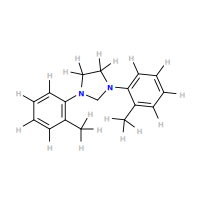

tBuSIMes  AF = 10.29 +/- 0.30


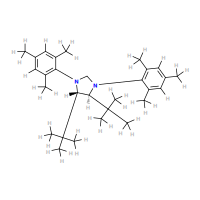

tetraMeSIPh  AF = 5.85 +/- 0.92


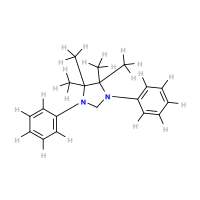

triphenylTriazole  AF = 8.01 +/- 0.06


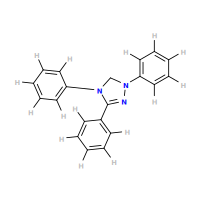

In [8]:
# Display the chemical structure of the ligands and the mean+std
from openbabel import pybel
from IPython.display import SVG, display

all_ligands = {}
for pathname_to_L in sorted(glob.glob('*/*-0_outSubXTB-L.sdf')):
    for mol in pybel.readfile('sdf', pathname_to_L):
        name = os.path.basename(pathname_to_L).replace('-0_outSubXTB-L.sdf','')
        mol.title = ""
        all_ligands[name] = mol


for index, row in df_summary.iterrows():
    print("%s  AF = %.2f +/- %.2f" % (index, row['mean'], row['std']))
    display(SVG(all_ligands[index].write("svg")))

Inspect data for series with large standard deviation: 'SpiroCAAC' and 'SpiroCAACDMeO'

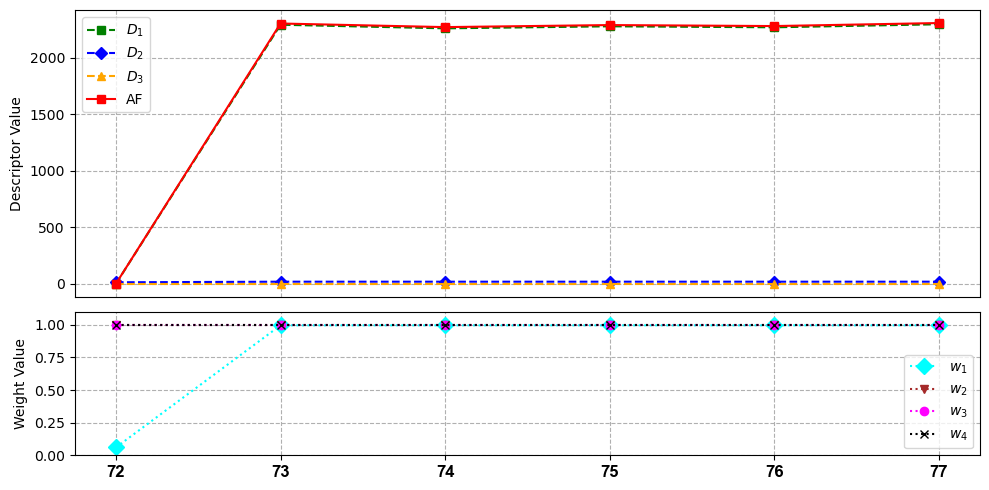

In [9]:
plot_one_series('SpiroCAAC')

For the first repetition, i.e., entry 72, both 'D_1' and 'w_1' are bringing the overall fitness to zero.

In [10]:
get_values_for_series(['freeEnergyD','freeEnergyX','freeEnergyZ'],'SpiroCAAC')

    freeEnergyD  freeEnergyX  freeEnergyZ
72 -2196.707147 -2275.205789 -2196.651498
73 -2196.707156 -2275.214166 -2196.651485
74 -2196.707157 -2275.214167 -2196.651500
75 -2196.707157 -2275.214174 -2196.651499
76 -2196.707156 -2275.214168 -2196.651497
77 -2196.707156 -2275.214167 -2196.651484


So, the energy of X, i.e., the transition state model for productive metathesis, and D, i.e., the MCB intermediate, are substantially off compared to the rest of the evaluations. In particular, for X the energy differs by ca. 5 kcal/mol! The source of these differences can be traced back to the conformation of the CAAC ligand chosen in this evaluation. Possibly, one of the CH2 of the ligand gets too close to the reacting part of the system, thus inducing a bit too much steric interaction.

We can exclude this data point 'SpiroCAAC-0' as an outlier resulting from an unfortunate conformational search.

The other entry with large standard deviation is 'SpiroCAACDMeO'

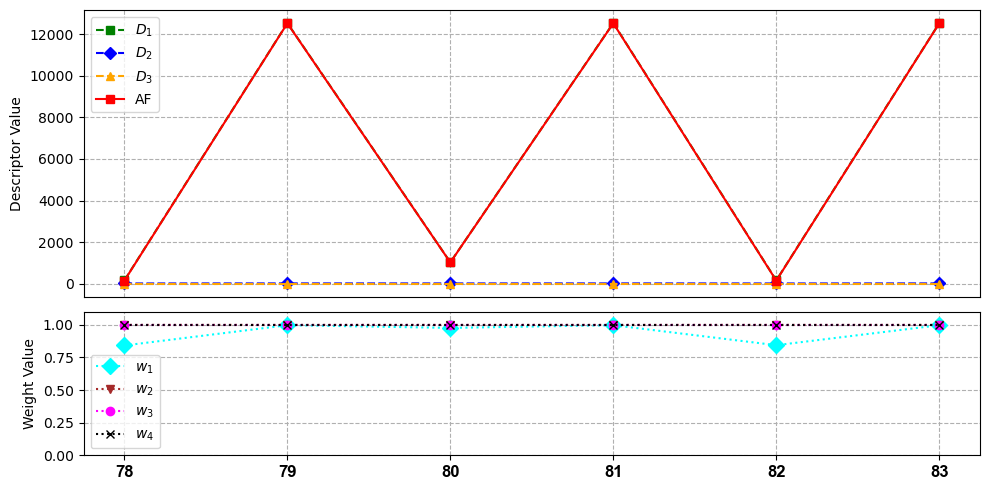

In [11]:
plot_one_series('SpiroCAACDMeO')

In [12]:
get_values_for_series(['freeEnergyD','freeEnergyX','freeEnergyZ'],'SpiroCAACDMeO')

    freeEnergyD  freeEnergyX  freeEnergyZ
78 -2425.514528 -2504.017560 -2425.457489
79 -2425.514505 -2504.021855 -2425.457490
80 -2425.514307 -2504.019396 -2425.457505
81 -2425.514514 -2504.021856 -2425.457490
82 -2425.514513 -2504.017561 -2425.457490
83 -2425.514512 -2504.021855 -2425.457490


Again the energy of the X model shows large oscilaltions (ca 2.7 kcal/mol) due to the selection of different conformations for CAAC ligand. 

If we exclude the 4 cases where the conformational search was presumably not good, we optain the purged dataset:

In [16]:
df_no_outlier_gruped = df_all_evaluations.drop(72).drop(78).drop(80).drop(82).groupby('NAME')
df_summary = df_no_outlier_gruped['FITNESS'].describe()


In [17]:
df_summary = df_summary.reindex(df_summary['mean'].sort_values().index)[['count','mean','std']]
df_summary

,count,mean,std
NAME,,,
CAACCyDIPP,6.0,0.722345,0.044484
IPrP,6.0,2.182486,2.004994
tetraMeSIPh,6.0,5.851131,0.918492
DFP,6.0,6.132873,0.550690
CyDIPP,6.0,7.656693,0.224664
triphenylTriazole,6.0,8.014728,0.055181
CpMes,6.0,8.327468,0.227441
SIMesI,6.0,9.010396,0.010916
dPhSIMesCyclohexyl,6.0,9.238926,1.206137


CAACCyDIPP  AF = 0.72 +/- 0.04


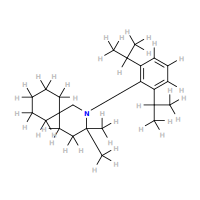

IPrP  AF = 2.18 +/- 2.00


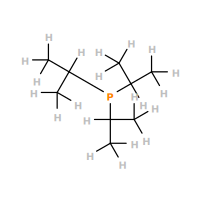

tetraMeSIPh  AF = 5.85 +/- 0.92


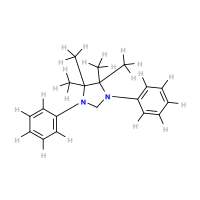

DFP  AF = 6.13 +/- 0.55


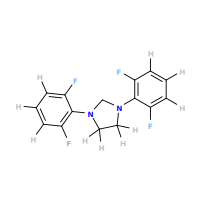

CyDIPP  AF = 7.66 +/- 0.22


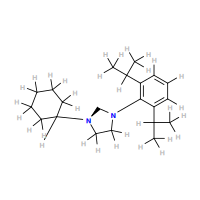

triphenylTriazole  AF = 8.01 +/- 0.06


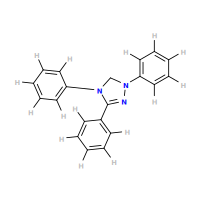

CpMes  AF = 8.33 +/- 0.23


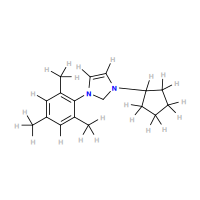

SIMesI  AF = 9.01 +/- 0.01


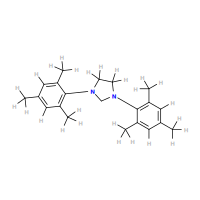

dPhSIMesCyclohexyl  AF = 9.24 +/- 1.21


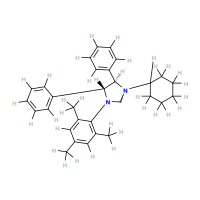

tBuSIMes  AF = 10.29 +/- 0.30


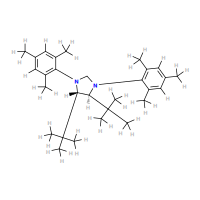

orthoTolyl  AF = 10.93 +/- 0.47


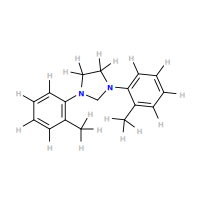

SIMesBenzyl  AF = 11.13 +/- 0.92


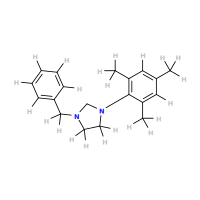

SIMesBr  AF = 11.97 +/- 0.08


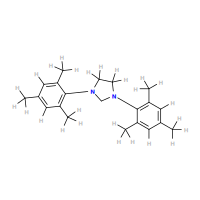

CAACEtDIPP  AF = 13.00 +/- 1.15


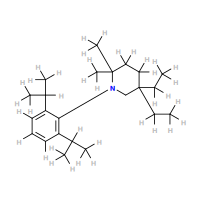

DIPP  AF = 14.12 +/- 0.10


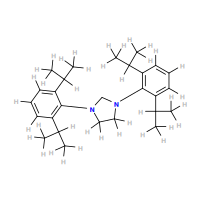

DIPP5CAAC  AF = 17.16 +/- 2.42


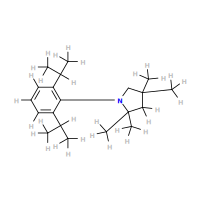

DMIMes  AF = 19.39 +/- 0.04


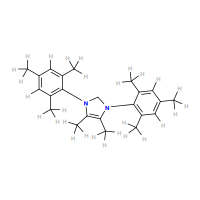

SpiroCAAC  AF = 2288.84 +/- 15.09


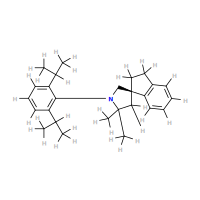

SpiroCAACDMeO  AF = 12514.64 +/- 3.00


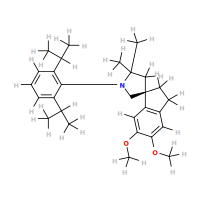

In [18]:
# Display the chemical structure of the ligands and the mean+std
for index, row in df_summary.iterrows():
    print("%s  AF = %.2f +/- %.2f" % (index, row['mean'], row['std']))
    display(SVG(all_ligands[index].write("svg")))

The score for DIPP5CAAC is a surprisingly higher than that of the 2nd generation Hoveyda-Grubbs catalyst (AF score = 15). Let's look into the source of the AF score for DIPP5CAAC:

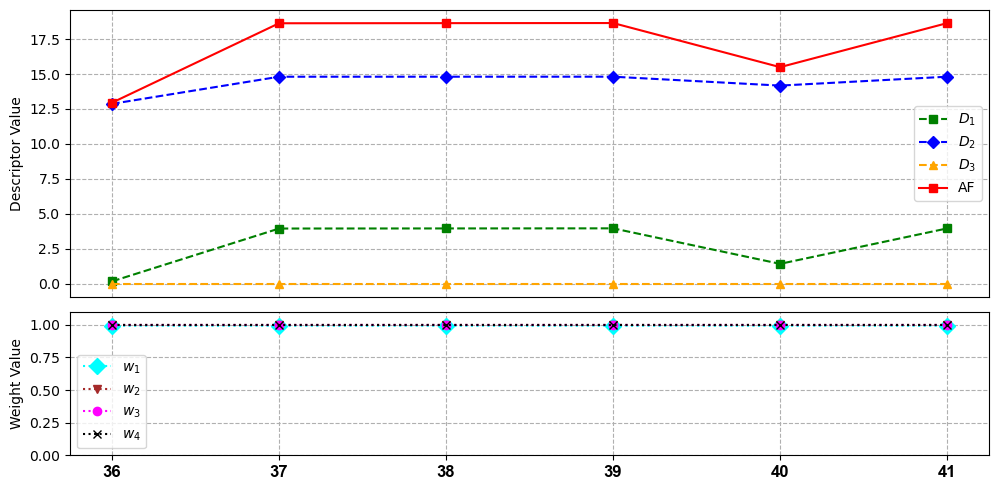

In [19]:
plot_one_series('DIPP5CAAC')

In [20]:
get_values_for_series(['freeEnergyD','freeEnergyX','freeEnergyZ'],'DIPP5CAAC')

    freeEnergyD  freeEnergyX  freeEnergyZ
36 -1967.096705 -2045.603005 -1967.049725
37 -1967.096705 -2045.603005 -1967.046634
38 -1967.096705 -2045.603006 -1967.046633
39 -1967.096701 -2045.603006 -1967.046631
40 -1967.096705 -2045.603006 -1967.047645
41 -1967.096705 -2045.603005 -1967.046632


It looks like the ligand conformation of repetition 0 leads to a lower freeEnergyZ than the other repetitions. However, this configuration somehow overlooked by the conformational search protocol.